In [2]:
import pandas_datareader as web
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.stats import norm
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.interpolate import interp1d
import numpy_financial as npf
import requests
from bs4 import BeautifulSoup

In [3]:

def generate_df(file_name):
    df = pd.read_csv(f"./data/coincodex2/{file_name}")
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date',inplace=True)
    df = df.iloc[::-1]
    df = df[df.index >= datetime(2020,12,1)]
    df.head()
    return df

In [4]:
eth_df = generate_df("ethereum_2020-12-1_2022-5-1.csv")
sol_df = generate_df("solana_2020-12-1_2022-5-1.csv")
avax_df = generate_df("avalanche_2020-12-1_2022-5-1.csv")
luna_df = generate_df("terra_2020-12-1_2022-5-1.csv")
near_df = generate_df("near-protocol_2020-12-1_2022-5-1.csv")
ftm_df = generate_df("fantom_2020-12-1_2022-5-1.csv")
near_df

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2020-12-01,1.074047,1.136187,1.006713,1.075536,6.359005e+07,2.129790e+08
2020-12-02,1.061392,1.200548,1.045444,1.176352,9.519486e+07,2.282041e+08
2020-12-03,1.178527,1.193433,1.137444,1.155287,3.854613e+07,2.285274e+08
2020-12-04,1.155418,1.221788,1.097605,1.106827,3.739559e+07,2.284427e+08
2020-12-05,1.103230,1.142237,1.023442,1.111261,5.681561e+07,2.111705e+08
...,...,...,...,...,...,...
2022-04-27,12.679900,13.236634,12.458217,12.821237,2.126101e+09,8.757228e+09
2022-04-28,12.865400,13.109000,12.279441,12.390900,1.587002e+09,8.640117e+09
2022-04-29,12.403400,12.523900,11.140600,11.238076,1.430643e+09,8.018380e+09


In [5]:
principal_usd = 100000000
coins = ['ETH','SOL','AVAX','LUNA','NEAR','FTM']
coin_allocations = [0.40,0.25,0.12,0.13,0.05,0.05]
sum(coin_allocations)
coin_principals = [i*principal_usd for i in coin_allocations]
coin_principals
coin_init_amounts = []

In [6]:
portfolio_df = pd.concat([eth_df['Close'],sol_df['Close'],avax_df['Close'],luna_df['Close'],near_df['Close'],ftm_df['Close']],axis=1)
portfolio_df.columns = coins
portfolio_df

,ETH,SOL,AVAX,LUNA,NEAR,FTM
Date,,,,,,
2020-12-01,589.814467,1.977516,3.576271,0.388320,1.075536,0.020539
2020-12-02,598.357253,2.112355,3.745825,0.406310,1.176352,0.022646
2020-12-03,616.904853,2.098405,3.819472,0.506414,1.155287,0.022888
2020-12-04,571.978333,1.856668,3.556966,0.451015,1.106827,0.021042
2020-12-05,595.548506,1.977440,3.630332,0.509040,1.111261,0.022497
...,...,...,...,...,...,...
2022-04-27,2893.559731,98.309653,69.829573,89.065569,12.821237,0.986282
2022-04-28,2938.545100,98.129000,67.262100,88.665600,12.390900,0.968966
2022-04-29,2817.726674,93.942711,63.307263,84.902554,11.238076,0.832615


In [7]:
r = requests.get('https://staked.us/yields/')
# print content of request
soup = BeautifulSoup(r.content, 'html.parser')
print(soup.prettify())


<!DOCTYPE html>
<html lang="en">
 <head>
  <!-- Required meta tags -->
  <meta charset="utf-8"/>
  <meta content="width=device-width, initial-scale=1, shrink-to-fit=no" name="viewport"/>
  <link href="https://storage.googleapis.com/static-webapp-220401-prod/static/css/cardillac_bb.277c57cbf40c.css" media="all" rel="stylesheet" type="text/css"/>
  <link href="https://storage.googleapis.com/static-webapp-220401-prod/static/css/style-v2.8a8d295635c9.css?3" media="all" rel="stylesheet" type="text/css"/>
  <link href="https://storage.googleapis.com/static-webapp-220401-prod/static/i/fav/apple-touch-icon.a348381cd490.png?v=gAa6AEel3x" rel="apple-touch-icon" sizes="180x180"/>
  <link href="https://storage.googleapis.com/static-webapp-220401-prod/static/i/fav/favicon-32x32.bbec3ad5d0d0.png?v=gAa6AEel3x" rel="icon" sizes="32x32" type="image/png"/>
  <link href="https://storage.googleapis.com/static-webapp-220401-prod/static/i/fav/favicon-16x16.6d35ef5acfb2.png?v=gAa6AEel3x" rel="icon" sizes="16

In [8]:
s = soup.find('table', class_='Assets-Table__table')
table_title = s.find('thead', class_='FT__head')
headers = table_title.find_all('th', class_='FT__cell')
#titles = s.find('div', class_='G--ib')
found_titles = []
for item in headers:
    found_titles.append(item.text.strip())
found_titles

['Project',
 'NominalYield %',
 'Staked %',
 'Inflation %',
 'RealYield %',
 'Lock-Up',
 'Market Cap ($)',
 'Daily Vol ($)',
 '']

In [9]:
table_body = s.find('tbody', class_='FT__body')
rows = table_body.find_all('tr', class_='FT__row')
columns = []
columns.append(found_titles)
for row in rows:
    result = row.find_all('td',class_='FT__cell')
    inner_result = []
    for r in result:
        if "\n" in r:
            #print(r.text.strip().split("\n"))
            core_result =r.text.strip().split("\n")
            #print(core_result)
            for z in core_result:
                inner_result.append(z.strip())
        else:
            inner_result.append(r.text.strip())
    columns.append(inner_result[0:9])
columns

[['Project',
  'NominalYield %',
  'Staked %',
  'Inflation %',
  'RealYield %',
  'Lock-Up',
  'Market Cap ($)',
  'Daily Vol ($)',
  ''],
 ['ETH2.0',
  'ETH2',
  '4.4%',
  '7.7%',
  '0.4%',
  '4.0%',
  '~12+ months',
  '512.18B',
  ''],
 ['Cardano',
  'ADA',
  '4.6%',
  '53.6%',
  '2.5%',
  '2.0%',
  'No Lock-Up',
  '14.52B',
  ''],
 ['Solana', 'SOL', '5.6%', '77.1%', '4.3%', '1.2%', '2 days', '13.82B', ''],
 ['Terra', 'LUNA', '7.7%', '37.8%', '---', '7.7%', '21 days', '13.82B', ''],
 ['Polkadot',
  'DOT',
  '14.7%',
  '53.2%',
  '7.8%',
  '6.4%',
  '28 days',
  '10.45B',
  ''],
 ['TRON', 'TRX', '6.0%', '31.8%', '1.1%', '4.8%', '-', '6.87B', ''],
 ['Cosmos', 'ATOM', '14.7%', '59.0%', '8.7%', '5.5%', '21 days', '6.46B', ''],
 ['Polygon',
  'MATIC',
  '11.3%',
  '34.0%',
  '3.9%',
  '7.1%',
  '9-10 days',
  '2.57B',
  ''],
 ['Elrond', 'EGLD', '17.9%', '52.8%', '9.4%', '7.8%', '-', '1.75B', ''],
 ['Tezos', 'XTZ', '9.0%', '99.0%', '8.9%', '0.1%', 'No Lock-Up', '1.60B', ''],
 ['Dash', 'DA

In [10]:
staked_yields_df = pd.DataFrame(columns=found_titles[:-1])
staked_yields_df['Project'] = [row[0] for row in columns[1:]]
staked_yields_df['NominalYield %'] = [row[2] for row in columns[1:]]
staked_yields_df['Staked %'] = [row[3] for row in columns[1:]]
staked_yields_df['Inflation %'] = [row[4] for row in columns[1:]]
staked_yields_df['RealYield %'] = [row[5] for row in columns[1:]]
staked_yields_df['Lock-Up'] = [row[6] for row in columns[1:]]
staked_yields_df['Market Cap ($)'] = [row[7] for row in columns[1:]]
staked_yields_df['Daily Vol ($)'] = [row[8] for row in columns[1:]]
staked_yields_df['Date'] = datetime(2022,5,5)
staked_yields_df

,Project,NominalYield %,Staked %,Inflation %,RealYield %,Lock-Up,Market Cap ($),Daily Vol ($),Date
0,ETH2.0,4.4%,7.7%,0.4%,4.0%,~12+ months,512.18B,,2022-05-05
1,Cardano,4.6%,53.6%,2.5%,2.0%,No Lock-Up,14.52B,,2022-05-05
2,Solana,5.6%,77.1%,4.3%,1.2%,2 days,13.82B,,2022-05-05
3,Terra,7.7%,37.8%,---,7.7%,21 days,13.82B,,2022-05-05
4,Polkadot,14.7%,53.2%,7.8%,6.4%,28 days,10.45B,,2022-05-05
5,TRON,6.0%,31.8%,1.1%,4.8%,-,6.87B,,2022-05-05
6,Cosmos,14.7%,59.0%,8.7%,5.5%,21 days,6.46B,,2022-05-05
7,Polygon,11.3%,34.0%,3.9%,7.1%,9-10 days,2.57B,,2022-05-05
8,Elrond,17.9%,52.8%,9.4%,7.8%,-,1.75B,,2022-05-05
9,Tezos,9.0%,99.0%,8.9%,0.1%,No Lock-Up,1.60B,,2022-05-05


In [11]:
def make_table(url,year,month,day):
    r = requests.get(url)
    # print content of request
    soup = BeautifulSoup(r.content, 'html.parser')
    #print(r.content)
    html_file = open(f"./html/data_{year}_{month}_{day}.html","wb")
    html_file.write(r.content)
    html_file.close()
    s = soup.find('table', class_='Assets-Table__table')
    table_title = s.find('thead', class_='FT__head')
    headers = table_title.find_all('th', class_='FT__cell')
    #titles = s.find('div', class_='G--ib')
    found_titles = []
    for item in headers:
        found_titles.append(item.text.strip())
    found_titles
    #print(found_titles)
    table_body = s.find('tbody', class_='FT__body')
    rows = table_body.find_all('tr', class_='FT__row')
    columns = []
    columns.append(found_titles)
    for row in rows:
        result = row.find_all('td',class_='FT__cell')
        inner_result = []
        for r in result:
            if "\n" in r:
                #print(r.text.strip().split("\n"))
                core_result =r.text.strip().split("\n")
                #print(core_result)
                for z in core_result:
                    inner_result.append(z.strip())
            else:
                inner_result.append(r.text.strip())
        columns.append(inner_result[0:9])
    #print(columns)
    staked_yields_df = pd.DataFrame(columns=found_titles[:-1])
    staked_yields_df['Project'] = [row[0] for row in columns[1:]]
    staked_yields_df['NominalYield %'] = [row[2] for row in columns[1:]]
    staked_yields_df['Staked %'] = [row[3] for row in columns[1:]]
    staked_yields_df['Inflation %'] = [row[4] for row in columns[1:]]
    staked_yields_df['RealYield %'] = [row[5] for row in columns[1:]]
    staked_yields_df['Lock-Up'] = [row[6] for row in columns[1:]]
    staked_yields_df['Market Cap ($)'] = [row[7] for row in columns[1:]]
    staked_yields_df['Daily Vol ($)'] = [row[8] for row in columns[1:]]
    staked_yields_df['Date'] = datetime(year,month,day)
    return staked_yields_df

In [12]:
june_6_2020_df = make_table("https://web.archive.org/web/20200610233558/staked.us/yields/",2020,6,10)
june_6_2020_df

,Project,NominalYield %,Staked %,Inflation %,RealYield %,Lock-Up,Market Cap ($),Daily Vol ($),Date
0,Ethereum,0.2%,---,5.0%,-4.6%,No Lock-Up,27.27B,,2020-06-10
1,Tezos,6.3%,79.6%,5.0%,1.2%,No Lock-Up,2.42B,,2020-06-10
2,Cardano,7.2%,---,---,7.2%,No Lock-Up,2.07B,,2020-06-10
3,Celo,6.0%,36.9%,---,6.0%,3 days,1.73B,,2020-06-10
4,TRON,2.9%,26.6%,0.8%,2.1%,-,1.36B,,2020-06-10
5,Cosmos,9.7%,70.5%,7.0%,2.5%,21 days,1.16B,,2020-06-10
6,Dash,6.7%,49.8%,7.5%,-0.7%,No Lock-Up,843.60M,,2020-06-10
7,USDC,3.5%,97.9%,---,3.4%,No Lock-Up,740.19M,,2020-06-10
8,Keep,---,---,---,---,---,380.00M,,2020-06-10
9,Decred,7.7%,49.8%,13.5%,-5.2%,~ 29 days,201.68M,,2020-06-10


In [13]:
oct_10_2020_df = make_table("https://web.archive.org/web/20191024000106/staked.us/yields/",2019,10,4)
oct_10_2020_df

,Project,Yield %,Staked %,Inflation %,Lock-Up,Market Cap ($),Daily Vol ($),NominalYield %,RealYield %,Date
0,Livepeer,NaN,59.8%,70.8%,"99,086,332","15,631",Rewards,144.7%,7 days,2019-10-04
1,Loom,NaN,20.0%,4.0%,"29,086,393","1,417,320",Rewards,20.0%,2w/3m/6m/1y,2019-10-04
2,Horizen,NaN,34.9%,34.2%,"38,795,634","144,230",Rewards,17.1%,No Lock-Up,2019-10-04
3,Algorand,NaN,11.4%,1.5%,"222,999,449","85,594,273",Rewards,16.6%,No Lock-Up,2019-10-04
4,V-Systems,NaN,39.5%,---,"322,235,606","12,118,020",Rewards,15.4%,No Lock-Up,2019-10-04
5,Iris,NaN,27.8%,4.0%,"11,096,825","4,738,056",Rewards,14.4%,21 days,2019-10-04
6,Orbs,NaN,---,---,"18,498,817","349,893",Stake,10.0%,---,2019-10-04
7,Cosmos,NaN,73.6%,6.9%,"630,246,904","121,441,294",Rewards,9.4%,21 days,2019-10-04
8,Decred,NaN,50.4%,16.5%,"256,455,759","992,399",Rewards,9.3%,~ 29 days,2019-10-04
9,Terra,NaN,22.2%,---,"1,270,000,000","1,919,852",Rewards,8.9%,21 days,2019-10-04


In [14]:
may_14_2020_df = make_table("https://web.archive.org/web/20200514002346/http://staked.us/yields/",2020,5,14)
may_14_2020_df

,Project,NominalYield %,Staked %,Inflation %,RealYield %,Lock-Up,Market Cap ($),Daily Vol ($),Date
0,Ethereum,0.2%,---,5.0%,-4.6%,No Lock-Up,22.03B,,2020-05-14
1,Tezos,6.3%,80.0%,5.0%,1.2%,No Lock-Up,2.13B,,2020-05-14
2,Cosmos,9.7%,73.9%,7.0%,2.5%,21 days,1.16B,,2020-05-14
3,Dash,6.7%,49.8%,7.5%,-0.7%,No Lock-Up,843.60M,,2020-05-14
4,Cardano,7.2%,---,---,7.2%,No Lock-Up,777.81M,,2020-05-14
5,USDC,1.0%,97.9%,---,1.0%,No Lock-Up,706.24M,,2020-05-14
6,V-Systems,17.8%,28.5%,5.0%,12.2%,No Lock-Up,322.24M,,2020-05-14
7,Decred,7.9%,49.4%,13.8%,-5.2%,~ 29 days,154.36M,,2020-05-14
8,ICON,16.0%,29.6%,8.5%,6.9%,5 - 20 days,146.60M,,2020-05-14
9,Algorand,5.6%,63.8%,1.5%,4.0%,No Lock-Up,141.63M,,2020-05-14


In [15]:
sep_18_2020_df = make_table("https://web.archive.org/web/20200514002346/http://staked.us/yields/",2020,9,18)
sep_18_2020_df

,Project,NominalYield %,Staked %,Inflation %,RealYield %,Lock-Up,Market Cap ($),Daily Vol ($),Date
0,Ethereum,0.2%,---,5.0%,-4.6%,No Lock-Up,22.03B,,2020-09-18
1,Tezos,6.3%,80.0%,5.0%,1.2%,No Lock-Up,2.13B,,2020-09-18
2,Cosmos,9.7%,73.9%,7.0%,2.5%,21 days,1.16B,,2020-09-18
3,Dash,6.7%,49.8%,7.5%,-0.7%,No Lock-Up,843.60M,,2020-09-18
4,Cardano,7.2%,---,---,7.2%,No Lock-Up,777.81M,,2020-09-18
5,USDC,1.0%,97.9%,---,1.0%,No Lock-Up,706.24M,,2020-09-18
6,V-Systems,17.8%,28.5%,5.0%,12.2%,No Lock-Up,322.24M,,2020-09-18
7,Decred,7.9%,49.4%,13.8%,-5.2%,~ 29 days,154.36M,,2020-09-18
8,ICON,16.0%,29.6%,8.5%,6.9%,5 - 20 days,146.60M,,2020-09-18
9,Algorand,5.6%,63.8%,1.5%,4.0%,No Lock-Up,141.63M,,2020-09-18


In [16]:
nov_12_2020_df = make_table("https://web.archive.org/web/20200514002346/http://staked.us/yields/",2020,11,12)
nov_12_2020_df

,Project,NominalYield %,Staked %,Inflation %,RealYield %,Lock-Up,Market Cap ($),Daily Vol ($),Date
0,Ethereum,0.2%,---,5.0%,-4.6%,No Lock-Up,22.03B,,2020-11-12
1,Tezos,6.3%,80.0%,5.0%,1.2%,No Lock-Up,2.13B,,2020-11-12
2,Cosmos,9.7%,73.9%,7.0%,2.5%,21 days,1.16B,,2020-11-12
3,Dash,6.7%,49.8%,7.5%,-0.7%,No Lock-Up,843.60M,,2020-11-12
4,Cardano,7.2%,---,---,7.2%,No Lock-Up,777.81M,,2020-11-12
5,USDC,1.0%,97.9%,---,1.0%,No Lock-Up,706.24M,,2020-11-12
6,V-Systems,17.8%,28.5%,5.0%,12.2%,No Lock-Up,322.24M,,2020-11-12
7,Decred,7.9%,49.4%,13.8%,-5.2%,~ 29 days,154.36M,,2020-11-12
8,ICON,16.0%,29.6%,8.5%,6.9%,5 - 20 days,146.60M,,2020-11-12
9,Algorand,5.6%,63.8%,1.5%,4.0%,No Lock-Up,141.63M,,2020-11-12


In [17]:
dec_4_2020_df = make_table("https://web.archive.org/web/20201204181525/https://staked.us/yields/",2020,12,4)
dec_4_2020_df

,Project,NominalYield %,Staked %,Inflation %,RealYield %,Lock-Up,Market Cap ($),Daily Vol ($),Date
0,ETH-2.0,18.1%,---,5.0%,12.5%,12 - 18 mon,66.91B,,2020-12-04
1,Ethereum,0.2%,---,5.0%,-4.6%,No Lock-Up,66.26B,,2020-12-04
2,Polkadot,5.3%,65.0%,3.4%,1.8%,28 days,5.09B,,2020-12-04
3,Cardano,4.8%,46.6%,---,4.8%,No Lock-Up,4.15B,,2020-12-04
4,USDC,7.8%,97.9%,---,7.8%,No Lock-Up,2.97B,,2020-12-04
5,TRON,7.9%,26.6%,0.8%,7.1%,-,2.07B,,2020-12-04
6,Tezos,6.1%,79.5%,4.8%,1.2%,No Lock-Up,2.00B,,2020-12-04
7,Celo,6.0%,36.9%,---,6.0%,3 days,1.82B,,2020-12-04
8,Cosmos,9.7%,71.2%,6.9%,2.6%,21 days,1.40B,,2020-12-04
9,Dai,5.5%,---,---,5.5%,No Lock-Up,1.13B,,2020-12-04


In [18]:
jan_1_2021_df = make_table("https://web.archive.org/web/20201204181525/https://staked.us/yields/",2021,1,12)
jan_1_2021_df

,Project,NominalYield %,Staked %,Inflation %,RealYield %,Lock-Up,Market Cap ($),Daily Vol ($),Date
0,ETH-2.0,18.1%,---,5.0%,12.5%,12 - 18 mon,66.91B,,2021-01-12
1,Ethereum,0.2%,---,5.0%,-4.6%,No Lock-Up,66.26B,,2021-01-12
2,Polkadot,5.3%,65.0%,3.4%,1.8%,28 days,5.09B,,2021-01-12
3,Cardano,4.8%,46.6%,---,4.8%,No Lock-Up,4.15B,,2021-01-12
4,USDC,7.8%,97.9%,---,7.8%,No Lock-Up,2.97B,,2021-01-12
5,TRON,7.9%,26.6%,0.8%,7.1%,-,2.07B,,2021-01-12
6,Tezos,6.1%,79.5%,4.8%,1.2%,No Lock-Up,2.00B,,2021-01-12
7,Celo,6.0%,36.9%,---,6.0%,3 days,1.82B,,2021-01-12
8,Cosmos,9.7%,71.2%,6.9%,2.6%,21 days,1.40B,,2021-01-12
9,Dai,5.5%,---,---,5.5%,No Lock-Up,1.13B,,2021-01-12


In [19]:
apr_20_2021_df = make_table("https://web.archive.org/web/20210420172525/https://staked.us/yields/",2021,4,20)
apr_20_2021_df

,Project,NominalYield %,Staked %,Inflation %,RealYield %,Lock-Up,Market Cap ($),Daily Vol ($),Date
0,ETH2.0,8.8%,3.3%,5.0%,3.6%,~12+ months,175.24B,,2021-04-20
1,Ethereum,1.0%,---,5.0%,-3.8%,No Lock-Up,175.24B,,2021-04-20
2,Polkadot,14.1%,60.0%,8.6%,5.1%,28 days,34.08B,,2021-04-20
3,Cardano,4.8%,46.6%,---,4.8%,No Lock-Up,31.37B,,2021-04-20
4,TRON,7.6%,26.6%,0.8%,6.8%,-,8.99B,,2021-04-20
5,USDC,10.5%,97.9%,---,10.5%,No Lock-Up,8.89B,,2021-04-20
6,Solana,12.9%,61.0%,7.9%,4.7%,2 days,8.02B,,2021-04-20
7,Cosmos,10.5%,65.9%,6.9%,3.3%,21 days,6.46B,,2021-04-20
8,Terra,4.8%,31.7%,---,4.8%,21 days,5.17B,,2021-04-20
9,Celo,6.0%,36.9%,---,6.0%,3 days,5.13B,,2021-04-20


In [20]:
may_17_2021_df = make_table("https://web.archive.org/web/20210517043419/https://www.staked.us/yields/",2021,5,17)
may_17_2021_df

,Project,NominalYield %,Staked %,Inflation %,RealYield %,Lock-Up,Market Cap ($),Daily Vol ($),Date
0,ETH2.0,7.3%,3.3%,5.0%,2.2%,~12+ months,374.75B,,2021-05-17
1,Ethereum,0.4%,---,5.0%,-4.4%,No Lock-Up,374.75B,,2021-05-17
2,Cardano,5.8%,51.2%,---,5.8%,No Lock-Up,54.71B,,2021-05-17
3,Polkadot,13.9%,64.0%,8.9%,4.6%,28 days,36.88B,,2021-05-17
4,Solana,11.5%,67.4%,7.9%,3.4%,2 days,11.84B,,2021-05-17
5,USDC,9.3%,97.9%,---,9.3%,No Lock-Up,10.83B,,2021-05-17
6,TRON,7.5%,26.6%,0.8%,6.6%,-,7.61B,,2021-05-17
7,Cosmos,10.5%,65.9%,6.9%,3.3%,21 days,6.46B,,2021-05-17
8,Matic,---,---,---,---,-,5.94B,,2021-05-17
9,Terra,4.5%,31.7%,---,4.5%,21 days,5.88B,,2021-05-17


In [21]:
june_16_2021_df = make_table("https://web.archive.org/web/20210616130603/https://staked.us/yields/",2021,6,16)
june_16_2021_df

,Project,NominalYield %,Staked %,Inflation %,RealYield %,Lock-Up,Market Cap ($),Daily Vol ($),Date
0,ETH2.0,6.8%,3.3%,5.0%,1.7%,~12+ months,283.74B,,2021-06-16
1,Ethereum,0.4%,---,5.0%,-4.4%,No Lock-Up,283.74B,,2021-06-16
2,Cardano,5.8%,51.2%,---,5.8%,No Lock-Up,39.41B,,2021-06-16
3,USDC,3.5%,97.9%,---,3.5%,No Lock-Up,23.77B,,2021-06-16
4,Polkadot,14.0%,62.0%,8.7%,4.9%,28 days,22.69B,,2021-06-16
5,Solana,11.5%,67.4%,7.9%,3.4%,2 days,9.94B,,2021-06-16
6,Cosmos,9.9%,70.7%,7.0%,2.7%,21 days,6.46B,,2021-06-16
7,Polygon,15.9%,32.8%,5.2%,10.1%,9-10 days,5.83B,,2021-06-16
8,Dai,3.7%,---,---,3.7%,No Lock-Up,5.25B,,2021-06-16
9,TRON,7.3%,26.6%,0.8%,6.5%,-,4.84B,,2021-06-16


In [22]:
aug_16_2021_df = make_table("https://web.archive.org/web/20210816023039/https://staked.us/yields/",2021,9,16)
aug_16_2021_df

,Project,NominalYield %,Staked %,Inflation %,RealYield %,Lock-Up,Market Cap ($),Daily Vol ($),Date
0,ETH2.0,6.8%,5.1%,5.0%,1.7%,~12+ months,364.63B,,2021-09-16
1,Ethereum,0.4%,---,5.0%,-4.4%,No Lock-Up,364.63B,,2021-09-16
2,Cardano,4.6%,71.7%,1.9%,2.7%,No Lock-Up,41.22B,,2021-09-16
3,USDC,3.9%,97.9%,---,3.9%,No Lock-Up,27.70B,,2021-09-16
4,Polkadot,14.0%,62.0%,8.7%,4.9%,28 days,20.40B,,2021-09-16
5,Solana,7.4%,67.7%,7.9%,-0.4%,2 days,10.62B,,2021-09-16
6,Terra,3.6%,31.7%,---,3.6%,21 days,6.48B,,2021-09-16
7,Cosmos,9.9%,70.7%,7.0%,2.7%,21 days,6.46B,,2021-09-16
8,Dai,4.3%,---,---,4.3%,No Lock-Up,5.65B,,2021-09-16
9,TRON,7.7%,26.6%,0.8%,6.8%,-,5.02B,,2021-09-16


In [23]:
nov_26_2021_df = make_table("https://web.archive.org/web/20211126034218/https://staked.us/yields/",2021,11,26)
nov_26_2021_df

,Project,NominalYield %,Staked %,Inflation %,RealYield %,Lock-Up,Market Cap ($),Daily Vol ($),Date
0,ETH2.0,5.4%,5.1%,0.4%,5.0%,~12+ months,512.18B,,2021-11-26
1,Solana,7.2%,76.9%,5.5%,1.6%,2 days,53.89B,,2021-11-26
2,Cardano,4.6%,52.2%,2.4%,2.1%,No Lock-Up,42.52B,,2021-11-26
3,Polkadot,13.9%,63.0%,8.8%,4.7%,28 days,38.15B,,2021-11-26
4,Terra,4.9%,35.1%,---,4.9%,21 days,13.82B,,2021-11-26
5,Algorand,4.0%,27.0%,1.3%,2.7%,No Lock-Up,11.27B,,2021-11-26
6,Elrond,12.0%,61.0%,7.3%,4.4%,-,8.37B,,2021-11-26
7,TRON,7.0%,31.8%,1.1%,5.8%,-,7.17B,,2021-11-26
8,Polygon,13.5%,28.6%,3.9%,9.2%,9-10 days,7.04B,,2021-11-26
9,Cosmos,10.7%,65.7%,7.0%,3.5%,21 days,6.46B,,2021-11-26


In [24]:
jan_31_2022_df = make_table("https://web.archive.org/web/20220131134807/https://staked.us/yields/",2022,1,31)
jan_31_2022_df

,Project,NominalYield %,Staked %,Inflation %,RealYield %,Lock-Up,Market Cap ($),Daily Vol ($),Date
0,ETH2.0,5.2%,7.7%,0.4%,4.7%,~12+ months,512.18B,,2022-01-31
1,Cardano,4.6%,53.6%,2.5%,2.0%,No Lock-Up,26.45B,,2022-01-31
2,Solana,5.6%,77.1%,4.3%,1.2%,2 days,23.95B,,2022-01-31
3,Polkadot,14.7%,53.2%,7.8%,6.4%,28 days,17.47B,,2022-01-31
4,Terra,7.7%,37.8%,---,7.7%,21 days,13.82B,,2022-01-31
5,Cosmos,14.7%,59.0%,8.7%,5.5%,21 days,6.46B,,2022-01-31
6,Polygon,11.3%,34.0%,3.9%,7.1%,9-10 days,5.98B,,2022-01-31
7,Elrond,17.9%,52.8%,9.4%,7.8%,-,2.68B,,2022-01-31
8,Near,12.1%,40.6%,4.9%,6.9%,36 hours,2.09B,,2022-01-31
9,Helium,6.2%,31.6%,1.9%,4.2%,~ 5 months,2.00B,,2022-01-31


In [25]:
may_5_2022_df = make_table("https://staked.us/yields/",2022,5,5)
may_5_2022_df

,Project,NominalYield %,Staked %,Inflation %,RealYield %,Lock-Up,Market Cap ($),Daily Vol ($),Date
0,ETH2.0,4.4%,7.7%,0.4%,4.0%,~12+ months,512.18B,,2022-05-05
1,Cardano,4.6%,53.6%,2.5%,2.0%,No Lock-Up,14.52B,,2022-05-05
2,Solana,5.6%,77.1%,4.3%,1.2%,2 days,13.82B,,2022-05-05
3,Terra,7.7%,37.8%,---,7.7%,21 days,13.82B,,2022-05-05
4,Polkadot,14.7%,53.2%,7.8%,6.4%,28 days,10.45B,,2022-05-05
5,TRON,6.0%,31.8%,1.1%,4.8%,-,6.87B,,2022-05-05
6,Cosmos,14.7%,59.0%,8.7%,5.5%,21 days,6.46B,,2022-05-05
7,Polygon,11.3%,34.0%,3.9%,7.1%,9-10 days,2.57B,,2022-05-05
8,Elrond,17.9%,52.8%,9.4%,7.8%,-,1.75B,,2022-05-05
9,Tezos,9.0%,99.0%,8.9%,0.1%,No Lock-Up,1.60B,,2022-05-05


In [26]:
may_6_2022_df = make_table("https://staked.us/yields/",2022,5,6)
may_6_2022_df

,Project,NominalYield %,Staked %,Inflation %,RealYield %,Lock-Up,Market Cap ($),Daily Vol ($),Date
0,ETH2.0,4.4%,7.7%,0.4%,4.0%,~12+ months,512.18B,,2022-05-06
1,Cardano,4.6%,53.6%,2.5%,2.0%,No Lock-Up,14.52B,,2022-05-06
2,Solana,5.6%,77.1%,4.3%,1.2%,2 days,13.82B,,2022-05-06
3,Terra,7.7%,37.8%,---,7.7%,21 days,13.82B,,2022-05-06
4,Polkadot,14.7%,53.2%,7.8%,6.4%,28 days,10.45B,,2022-05-06
5,TRON,6.0%,31.8%,1.1%,4.8%,-,6.87B,,2022-05-06
6,Cosmos,14.7%,59.0%,8.7%,5.5%,21 days,6.46B,,2022-05-06
7,Polygon,11.3%,34.0%,3.9%,7.1%,9-10 days,2.57B,,2022-05-06
8,Elrond,17.9%,52.8%,9.4%,7.8%,-,1.75B,,2022-05-06
9,Tezos,9.0%,99.0%,8.9%,0.1%,No Lock-Up,1.60B,,2022-05-06


In [27]:
may_7_2022_df = make_table("https://staked.us/yields/",2022,5,7)
may_7_2022_df

,Project,NominalYield %,Staked %,Inflation %,RealYield %,Lock-Up,Market Cap ($),Daily Vol ($),Date
0,ETH2.0,4.4%,7.7%,0.4%,4.0%,~12+ months,512.18B,,2022-05-07
1,Cardano,4.6%,53.6%,2.5%,2.0%,No Lock-Up,14.52B,,2022-05-07
2,Solana,5.6%,77.1%,4.3%,1.2%,2 days,13.82B,,2022-05-07
3,Terra,7.7%,37.8%,---,7.7%,21 days,13.82B,,2022-05-07
4,Polkadot,14.7%,53.2%,7.8%,6.4%,28 days,10.45B,,2022-05-07
5,TRON,6.0%,31.8%,1.1%,4.8%,-,6.87B,,2022-05-07
6,Cosmos,14.7%,59.0%,8.7%,5.5%,21 days,6.46B,,2022-05-07
7,Polygon,11.3%,34.0%,3.9%,7.1%,9-10 days,2.57B,,2022-05-07
8,Elrond,17.9%,52.8%,9.4%,7.8%,-,1.75B,,2022-05-07
9,Tezos,9.0%,99.0%,8.9%,0.1%,No Lock-Up,1.60B,,2022-05-07


# Model Columns

Rolling lock up periods, first tranche of allocation has a lock up period of say t+20 then 5 days later we add in more and that pushes the next tranche to t+5+20, 

| Date | $ Value of the Portfolio (NAV) | Allocation for Each Coin (6) | (#) Amount Of Coin (6) | (%) APY Per Coin (6) | Lock in Date | Lock Up Period | Unlock Date [An Array of Tranches] | % Stacked Per Coin | # of Transactions | Market Cap $ |

In [28]:
class Portfolio:
    def __init__(self):
        self.net = 1000000
        self.eth_allocation = 0.40
        self.sol_allocation = 0.25
        self.avax_allocation = 0.12
        self.luna_allocation = 0.13
        self.near_allocation = 0.05
        self.ftm_allocation = 0.05
        self.eth_amount = 0

In [29]:
p = Portfolio()
p.net

1000000

In [30]:
def is_int(value):
    try:
        a = int(value)
        return True
    except:
        return False


def parse_column(input_df, column_name):
    return input_df[column_name].apply(lambda x: x.replace('%','').strip() if x != '---' and '21 days' != x else 0.0 ).astype(float)

def populate_sub_df(input_dfs,symbol):    
    my_df = pd.concat([input_df.loc[(symbol == input_df["Project"])] for input_df in input_dfs])
    my_df.reset_index(inplace=True)
    my_df.set_index('Date',inplace=True)
    my_df.sort_index(inplace=True)
    my_df['Inflation %'] = parse_column(my_df,'Inflation %')
    my_df['NominalYield %'] = parse_column(my_df,'NominalYield %')
    my_df['Staked %'] = parse_column(my_df,'Staked %')
    my_df['RealYield %'] = parse_column(my_df,'RealYield %')
    return my_df

In [31]:
date_dfs = [june_6_2020_df,oct_10_2020_df,may_14_2020_df,sep_18_2020_df,nov_12_2020_df,dec_4_2020_df,jan_1_2021_df,apr_20_2021_df,may_17_2021_df,june_16_2021_df,aug_16_2021_df,nov_26_2021_df,jan_31_2022_df,may_5_2022_df,may_6_2022_df,may_7_2022_df]

In [32]:
near_df = populate_sub_df(date_dfs,"Near")
near_df

,index,Project,NominalYield %,Staked %,Inflation %,RealYield %,Lock-Up,Market Cap ($),Daily Vol ($),Yield %
Date,,,,,,,,,,
2020-12-04,31,Near,9.0,0.0,5.0,3.8,36 hours,---,---,NaN
2021-01-12,31,Near,9.0,0.0,5.0,3.8,36 hours,---,---,NaN
2021-04-20,21,Near,10.3,0.0,5.0,5.0,36 hours,980.62M,,NaN
2021-05-17,19,Near,10.3,0.0,5.0,5.0,36 hours,1.04B,,NaN
2021-06-16,21,Near,10.3,0.0,5.0,5.0,36 hours,602.55M,,NaN
2021-09-16,21,Near,10.3,0.0,5.0,5.0,36 hours,559.23M,,NaN
2021-11-26,14,Near,11.0,92.7,10.2,0.7,36 hours,1.83B,,NaN
2022-01-31,8,Near,12.1,40.6,4.9,6.9,36 hours,2.09B,,NaN
2022-05-05,11,Near,12.1,40.6,4.9,6.9,36 hours,1.30B,,NaN


In [33]:
sol_df = populate_sub_df(date_dfs,"Solana")
sol_df

,index,Project,NominalYield %,Staked %,Inflation %,RealYield %,Lock-Up,Market Cap ($),Daily Vol ($),Yield %
Date,,,,,,,,,,
2021-04-20,6,Solana,12.9,61.0,7.9,4.7,2 days,8.02B,,NaN
2021-05-17,4,Solana,11.5,67.4,7.9,3.4,2 days,11.84B,,NaN
2021-06-16,5,Solana,11.5,67.4,7.9,3.4,2 days,9.94B,,NaN
2021-09-16,5,Solana,7.4,67.7,7.9,-0.4,2 days,10.62B,,NaN
2021-11-26,1,Solana,7.2,76.9,5.5,1.6,2 days,53.89B,,NaN
2022-01-31,2,Solana,5.6,77.1,4.3,1.2,2 days,23.95B,,NaN
2022-05-05,2,Solana,5.6,77.1,4.3,1.2,2 days,13.82B,,NaN
2022-05-06,2,Solana,5.6,77.1,4.3,1.2,2 days,13.82B,,NaN
2022-05-07,2,Solana,5.6,77.1,4.3,1.2,2 days,13.82B,,NaN


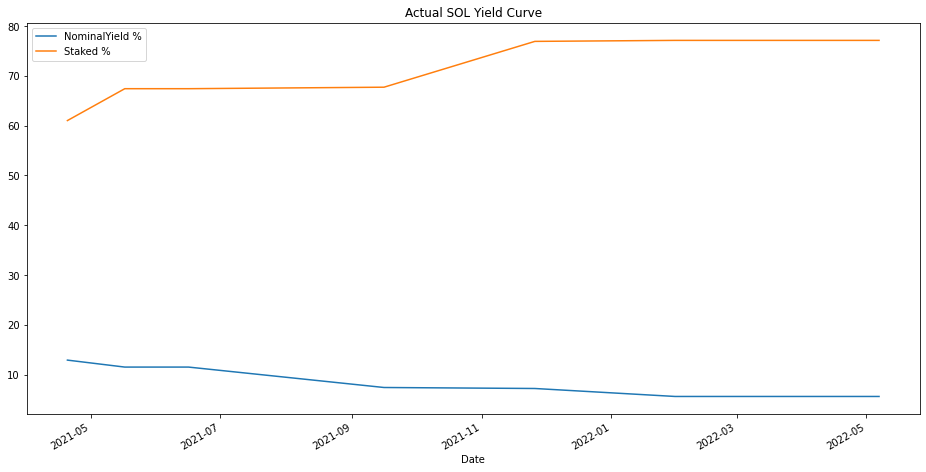

In [34]:

pl = sol_df.plot(y=['NominalYield %','Staked %'],figsize=(16,8),title='Actual SOL Yield Curve')

In [35]:
luna_df = populate_sub_df(date_dfs,"Terra")
luna_df

,index,Project,NominalYield %,Staked %,Inflation %,RealYield %,Lock-Up,Market Cap ($),Daily Vol ($),Yield %
Date,,,,,,,,,,
2019-10-04,9,Terra,8.9,22.2,0.0,0.0,"1,270,000,000","1,919,852",Rewards,NaN
2020-05-14,13,Terra,10.7,25.0,0.0,10.7,21 days,54.68M,,NaN
2020-06-10,17,Terra,14.9,25.0,0.0,14.9,21 days,60.43M,,NaN
2020-09-18,13,Terra,10.7,25.0,0.0,10.7,21 days,54.68M,,NaN
2020-11-12,13,Terra,10.7,25.0,0.0,10.7,21 days,54.68M,,NaN
2020-12-04,22,Terra,13.9,28.1,0.0,13.9,21 days,119.74M,,NaN
2021-01-12,22,Terra,13.9,28.1,0.0,13.9,21 days,119.74M,,NaN
2021-04-20,8,Terra,4.8,31.7,0.0,4.8,21 days,5.17B,,NaN
2021-05-17,9,Terra,4.5,31.7,0.0,4.5,21 days,5.88B,,NaN


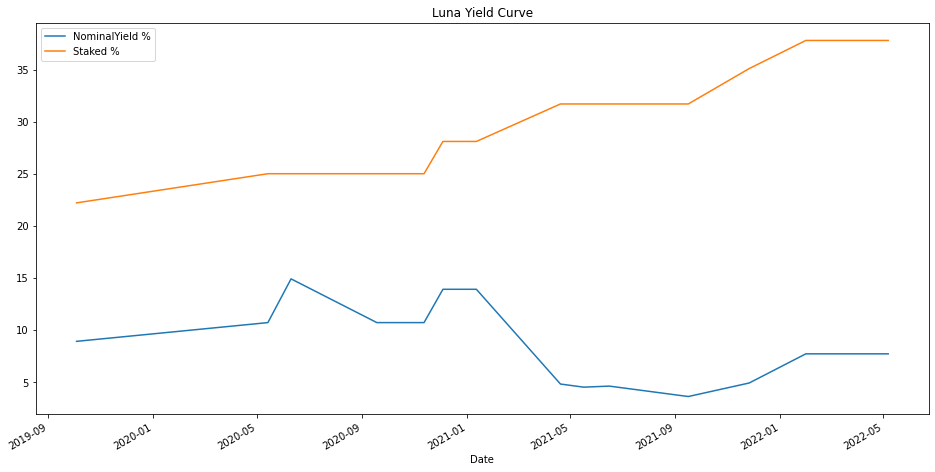

In [36]:
pl = luna_df.plot(y=['NominalYield %','Staked %'],figsize=(16,8),title='Luna Yield Curve')

In [37]:
eth_df = populate_sub_df(date_dfs,"ETH2.0")
eth_df

,index,Project,NominalYield %,Staked %,Inflation %,RealYield %,Lock-Up,Market Cap ($),Daily Vol ($),Yield %
Date,,,,,,,,,,
2021-04-20,0,ETH2.0,8.8,3.3,5.0,3.6,~12+ months,175.24B,,NaN
2021-05-17,0,ETH2.0,7.3,3.3,5.0,2.2,~12+ months,374.75B,,NaN
2021-06-16,0,ETH2.0,6.8,3.3,5.0,1.7,~12+ months,283.74B,,NaN
2021-09-16,0,ETH2.0,6.8,5.1,5.0,1.7,~12+ months,364.63B,,NaN
2021-11-26,0,ETH2.0,5.4,5.1,0.4,5.0,~12+ months,512.18B,,NaN
2022-01-31,0,ETH2.0,5.2,7.7,0.4,4.7,~12+ months,512.18B,,NaN
2022-05-05,0,ETH2.0,4.4,7.7,0.4,4.0,~12+ months,512.18B,,NaN
2022-05-06,0,ETH2.0,4.4,7.7,0.4,4.0,~12+ months,512.18B,,NaN
2022-05-07,0,ETH2.0,4.4,7.7,0.4,4.0,~12+ months,512.18B,,NaN


In [38]:
dot_df = populate_sub_df(date_dfs,"Polkadot")
dot_df

,index,Project,NominalYield %,Staked %,Inflation %,RealYield %,Lock-Up,Market Cap ($),Daily Vol ($),Yield %
Date,,,,,,,,,,
2020-12-04,2,Polkadot,5.3,65.0,3.4,1.8,28 days,5.09B,,NaN
2021-01-12,2,Polkadot,5.3,65.0,3.4,1.8,28 days,5.09B,,NaN
2021-04-20,2,Polkadot,14.1,60.0,8.6,5.1,28 days,34.08B,,NaN
2021-05-17,3,Polkadot,13.9,64.0,8.9,4.6,28 days,36.88B,,NaN
2021-06-16,4,Polkadot,14.0,62.0,8.7,4.9,28 days,22.69B,,NaN
2021-09-16,4,Polkadot,14.0,62.0,8.7,4.9,28 days,20.40B,,NaN
2021-11-26,3,Polkadot,13.9,63.0,8.8,4.7,28 days,38.15B,,NaN
2022-01-31,3,Polkadot,14.7,53.2,7.8,6.4,28 days,17.47B,,NaN
2022-05-05,4,Polkadot,14.7,53.2,7.8,6.4,28 days,10.45B,,NaN


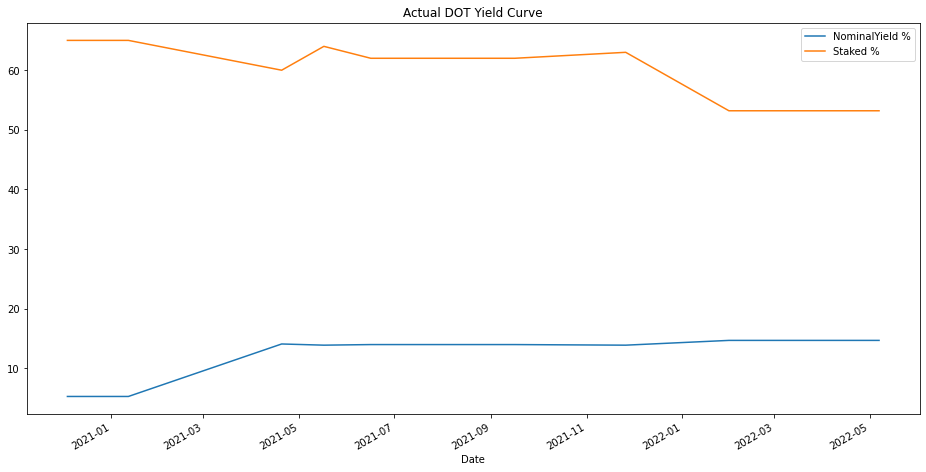

In [39]:
pl = dot_df.plot(y=['NominalYield %','Staked %'],figsize=(16,8),title='Actual DOT Yield Curve')

In [40]:
matic_df = populate_sub_df(date_dfs,"Polygon")
matic_df

,index,Project,NominalYield %,Staked %,Inflation %,RealYield %,Lock-Up,Market Cap ($),Daily Vol ($),Yield %
Date,,,,,,,,,,
2021-06-16,7,Polygon,15.9,32.8,5.2,10.1,9-10 days,5.83B,,NaN
2021-09-16,10,Polygon,14.9,35.0,5.2,9.2,9-10 days,4.31B,,NaN
2021-11-26,8,Polygon,13.5,28.6,3.9,9.2,9-10 days,7.04B,,NaN
2022-01-31,6,Polygon,11.3,34.0,3.9,7.1,9-10 days,5.98B,,NaN
2022-05-05,7,Polygon,11.3,34.0,3.9,7.1,9-10 days,2.57B,,NaN
2022-05-06,7,Polygon,11.3,34.0,3.9,7.1,9-10 days,2.57B,,NaN
2022-05-07,7,Polygon,11.3,34.0,3.9,7.1,9-10 days,2.57B,,NaN


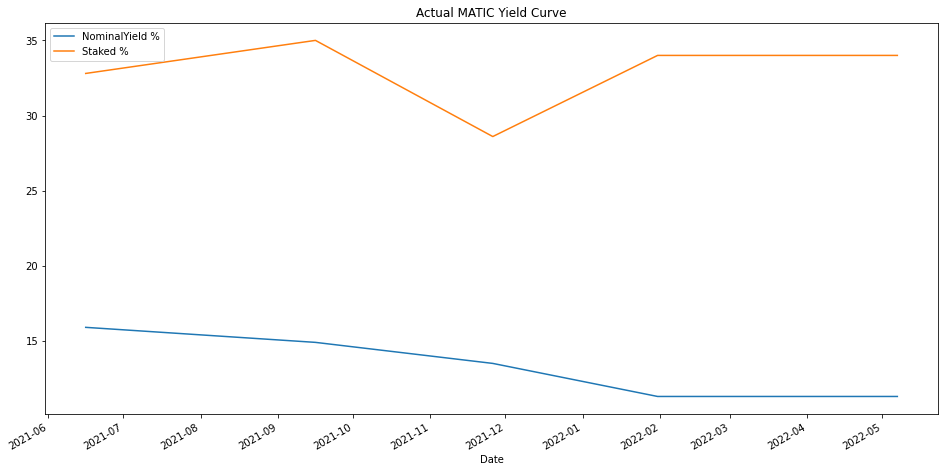

In [41]:
pl = matic_df.plot(y=['NominalYield %','Staked %'],figsize=(16,8),title='Actual MATIC Yield Curve')

In [42]:
atom_df = populate_sub_df(date_dfs,"Cosmos")
atom_df

,index,Project,NominalYield %,Staked %,Inflation %,RealYield %,Lock-Up,Market Cap ($),Daily Vol ($),Yield %
Date,,,,,,,,,,
2019-10-04,7,Cosmos,9.4,73.6,6.9,0.0,"630,246,904","121,441,294",Rewards,NaN
2020-05-14,2,Cosmos,9.7,73.9,7.0,2.5,21 days,1.16B,,NaN
2020-06-10,5,Cosmos,9.7,70.5,7.0,2.5,21 days,1.16B,,NaN
2020-09-18,2,Cosmos,9.7,73.9,7.0,2.5,21 days,1.16B,,NaN
2020-11-12,2,Cosmos,9.7,73.9,7.0,2.5,21 days,1.16B,,NaN
2020-12-04,8,Cosmos,9.7,71.2,6.9,2.6,21 days,1.40B,,NaN
2021-01-12,8,Cosmos,9.7,71.2,6.9,2.6,21 days,1.40B,,NaN
2021-04-20,7,Cosmos,10.5,65.9,6.9,3.3,21 days,6.46B,,NaN
2021-05-17,7,Cosmos,10.5,65.9,6.9,3.3,21 days,6.46B,,NaN


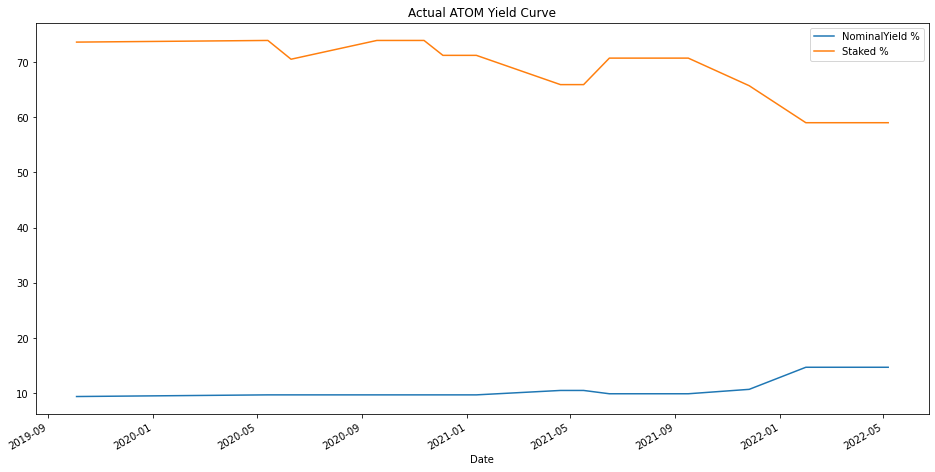

In [43]:
pl = atom_df.plot(y=['NominalYield %','Staked %'],figsize=(16,8),title='Actual ATOM Yield Curve')

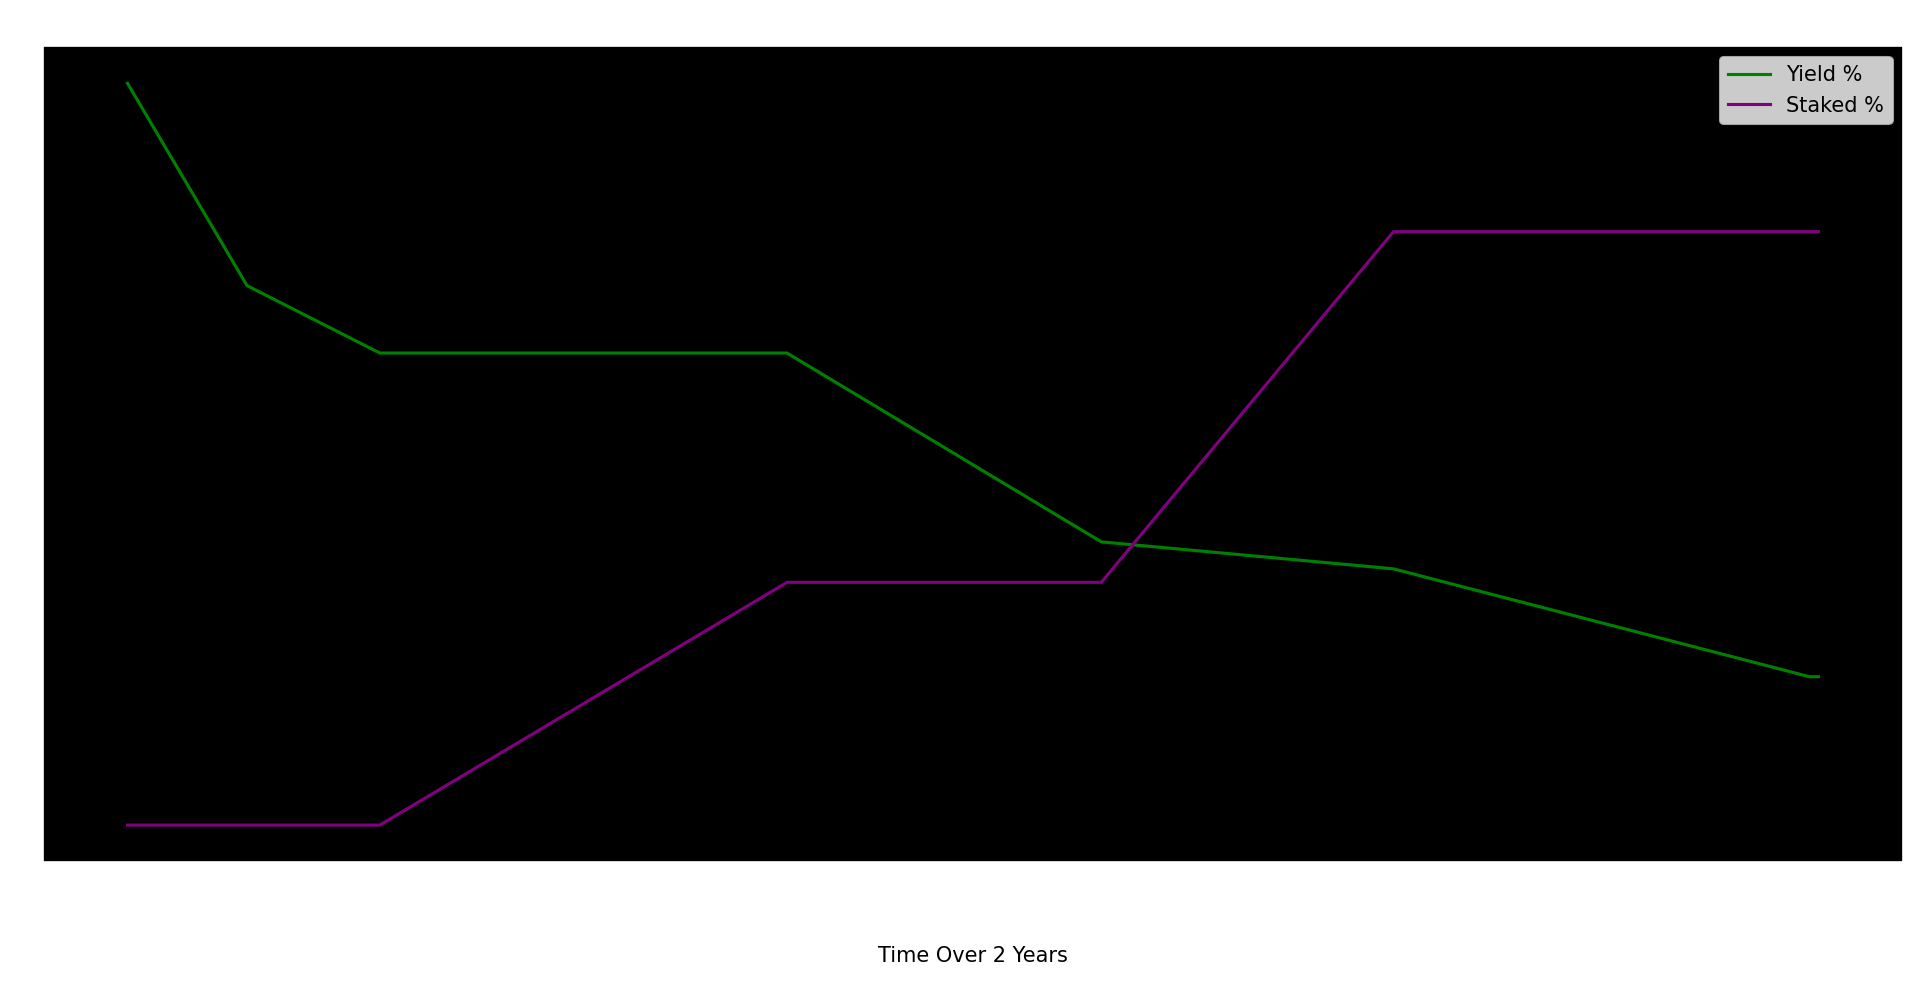

In [44]:
#pl = eth_df.plot(y=['NominalYield %','RealYield %','Staked %'],figsize=(16,8),title='Ethereum 2.0 Model Staking Dynamics')
#plt.plot(eth_df['NominalYield %'],eth_df['RealYield %'],eth_df['Date'])

# pl = eth_df.plot(y=['NominalYield %'],figsize=(16,8),title='Ethereum 2.0 Model Staking Dynamics',color = 'green')
# pl = eth_df.plot(y=['RealYield %'],figsize=(16,8),title='Ethereum 2.0 Model Staking Dynamics',color = 'red')

# ax = plt.axes()

# ax.spines['bottom'].set_color('green')
# ax.spines['top'].set_color('green') 
# ax.spines['right'].set_color('green')
# ax.spines['left'].set_color('green')
# ax.tick_params(axis='x', colors='white')
# ax.tick_params(axis='y', colors='white')
#ax.set_facecolor("white");



# code
# Visualizing The Open Price of all the stocks
  
# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)
ax = plt.axes()

ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.set_facecolor("black");
# using plot method to plot open prices.
# in plot method we set the label and color of the curve.
eth_df['NominalYield %'].plot(label='Yield %', color='green')
#eth_df['RealYield %'].plot(label='RealYield %', color='yellow')
eth_df['Staked %'].plot(label='Staked %', color='purple')
  
# adding title to the plot
plt.title('Ethereum 2.0 Model Staking Dynamics',color="white")
  
# adding Label to the x-axis
plt.xlabel('Time Over 2 Years')
  
# adding legend to the curve
plt.legend()






In [74]:
def get_data(coin):
    """
    {
      "daily_volume": 0.0, 
      "date": "Sat, 07 May 2022 15:00:35 GMT", 
      "id": 119, 
      "inflation_percentage": 0.0, 
      "lock_up_period": "21 days", 
      "market_cap": 13.82, 
      "nominal_yield": 7.7, 
      "project": "terra", 
      "real_yield": 7.7, 
      "staked_percentage": 37.8
    }, 
    #         staked_yields_df['Project'] = [row[0] for row in columns[1:]]
    #         staked_yields_df['NominalYield %'] = [row[2] for row in columns[1:]]
    #         staked_yields_df['Staked %'] = [row[3] for row in columns[1:]]
    #         staked_yields_df['Inflation %'] = [row[4] for row in columns[1:]]
    #         staked_yields_df['RealYield %'] = [row[5] for row in columns[1:]]
    #         staked_yields_df['Lock-Up'] = [row[6] for row in columns[1:]]
    #         staked_yields_df['Market Cap ($)'] = [row[7] for row in columns[1:]]
    #         staked_yields_df['Daily Vol ($)'] = [row[8] for row in columns[1:]]
    #         staked_yields_df['Date'] = datetime(year,month,day)
    
    """
    raw = requests.get(f"https://staking-web-crawler-app-udgwrbmbda-nw.a.run.app/api/v1/staking-yield/data/{coin}")
    json_response = raw.json()
    data_result = json_response["data"]
    result = []
    for data in data_result:
        row = [data["project"],data["nominal_yield"],data['staked_percentage'],data['inflation_percentage'],
              data['real_yield'],data['lock_up_period'],data['market_cap'],data['daily_volume'],data['date']]
        result.append(row)
    new_df = pd.DataFrame(columns=found_titles[:-1])
    new_df['Project'] = [row[0] for row in result]
    new_df['NominalYield %'] = [row[1] for row in result]
    new_df['Staked %'] = [row[2] for row in result]
    new_df['Inflation %'] = [row[3] for row in result]
    new_df['RealYield %'] = [row[4] for row in result]
    new_df['Lock-Up'] = [row[5] for row in result]
    new_df['Market Cap ($)'] = [row[6] for row in result]
    new_df['Daily Vol ($)'] = [row[7] for row in result]
    new_df['Date'] = [row[8] for row in result]
    new_df.reset_index(inplace=True)
    new_df.set_index('Date',inplace=True)
   #new_df.sort_index(inplace=True)
    return new_df       
    

In [75]:
luna_2_df = get_data("terra")
luna_2_df.tail()

,index,Project,NominalYield %,Staked %,Inflation %,RealYield %,Lock-Up,Market Cap ($),Daily Vol ($)
Date,,,,,,,,,
"Thu, 12 May 2022 19:00:04 GMT",210,terra,7.7,37.8,0.0,7.7,21 days,13.82,0.0
"Thu, 12 May 2022 23:00:05 GMT",211,terra,7.7,37.8,0.0,7.7,21 days,13.82,0.0
"Fri, 13 May 2022 23:00:04 GMT",212,terra,7.7,37.8,0.0,7.7,21 days,13.82,0.0
"Sat, 14 May 2022 23:00:05 GMT",213,terra,7.7,37.8,0.0,7.7,21 days,13.82,0.0
"Sun, 15 May 2022 23:00:05 GMT",214,terra,7.7,37.8,0.0,7.7,21 days,13.82,0.0


In [76]:
merged_luna_df = pd.concat([luna_df,luna_2_df])
merged_luna_df

,index,Project,NominalYield %,Staked %,Inflation %,RealYield %,Lock-Up,Market Cap ($),Daily Vol ($),Yield %
Date,,,,,,,,,,
2019-10-04 00:00:00,9,Terra,8.9,22.2,0.0,0.0,"1,270,000,000","1,919,852",Rewards,NaN
2020-05-14 00:00:00,13,Terra,10.7,25.0,0.0,10.7,21 days,54.68M,,NaN
2020-06-10 00:00:00,17,Terra,14.9,25.0,0.0,14.9,21 days,60.43M,,NaN
2020-09-18 00:00:00,13,Terra,10.7,25.0,0.0,10.7,21 days,54.68M,,NaN
2020-11-12 00:00:00,13,Terra,10.7,25.0,0.0,10.7,21 days,54.68M,,NaN
...,...,...,...,...,...,...,...,...,...,...
"Thu, 12 May 2022 19:00:04 GMT",210,terra,7.7,37.8,0.0,7.7,21 days,13.82,0.0,NaN
"Thu, 12 May 2022 23:00:05 GMT",211,terra,7.7,37.8,0.0,7.7,21 days,13.82,0.0,NaN
"Fri, 13 May 2022 23:00:04 GMT",212,terra,7.7,37.8,0.0,7.7,21 days,13.82,0.0,NaN


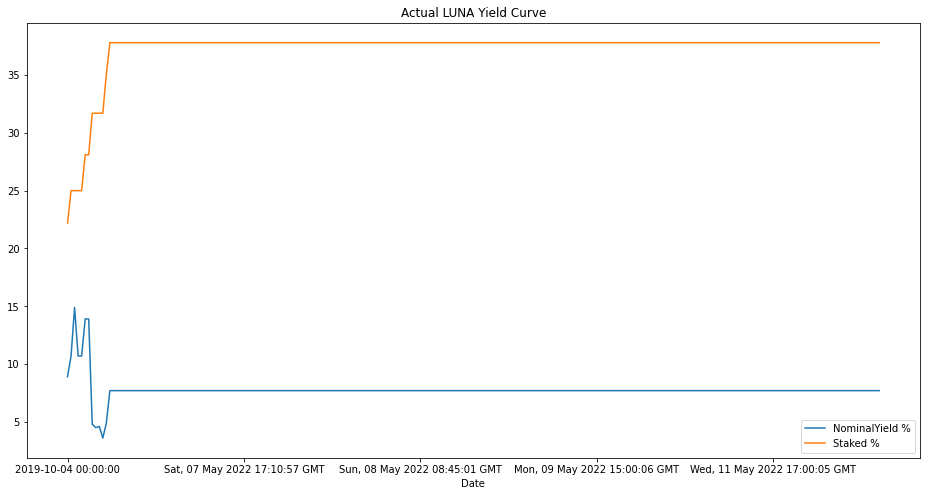

In [77]:
pl = merged_luna_df.plot(y=['NominalYield %','Staked %'],figsize=(16,8),title='Actual LUNA Yield Curve')

In [78]:
sol_2_df = get_data("solana")
sol_2_df

,index,Project,NominalYield %,Staked %,Inflation %,RealYield %,Lock-Up,Market Cap ($),Daily Vol ($)
Date,,,,,,,,,
"Sat, 07 May 2022 14:59:20 GMT",0,solana,5.6,77.1,4.3,1.2,2 days,21.41,0.0
"Sat, 07 May 2022 14:59:21 GMT",1,solana,5.6,77.1,4.3,1.2,2 days,21.41,0.0
"Sat, 07 May 2022 15:00:34 GMT",2,solana,5.6,77.1,4.3,1.2,2 days,21.41,0.0
"Sat, 07 May 2022 15:00:35 GMT",3,solana,5.6,77.1,4.3,1.2,2 days,21.41,0.0
"Sat, 07 May 2022 15:02:33 GMT",4,solana,5.6,77.1,4.3,1.2,2 days,21.41,0.0
...,...,...,...,...,...,...,...,...,...
"Thu, 12 May 2022 19:00:04 GMT",211,solana,5.6,77.1,4.3,1.2,2 days,11.82,0.0
"Thu, 12 May 2022 23:00:05 GMT",212,solana,5.6,77.1,4.3,1.2,2 days,11.20,0.0
"Fri, 13 May 2022 23:00:04 GMT",213,solana,5.6,77.1,4.3,1.2,2 days,13.33,0.0


In [79]:
merged_sol_df = pd.concat([sol_df,sol_2_df])
merged_sol_df

,index,Project,NominalYield %,Staked %,Inflation %,RealYield %,Lock-Up,Market Cap ($),Daily Vol ($),Yield %
Date,,,,,,,,,,
2021-04-20 00:00:00,6,Solana,12.9,61.0,7.9,4.7,2 days,8.02B,,NaN
2021-05-17 00:00:00,4,Solana,11.5,67.4,7.9,3.4,2 days,11.84B,,NaN
2021-06-16 00:00:00,5,Solana,11.5,67.4,7.9,3.4,2 days,9.94B,,NaN
2021-09-16 00:00:00,5,Solana,7.4,67.7,7.9,-0.4,2 days,10.62B,,NaN
2021-11-26 00:00:00,1,Solana,7.2,76.9,5.5,1.6,2 days,53.89B,,NaN
...,...,...,...,...,...,...,...,...,...,...
"Thu, 12 May 2022 19:00:04 GMT",211,solana,5.6,77.1,4.3,1.2,2 days,11.82,0.0,NaN
"Thu, 12 May 2022 23:00:05 GMT",212,solana,5.6,77.1,4.3,1.2,2 days,11.2,0.0,NaN
"Fri, 13 May 2022 23:00:04 GMT",213,solana,5.6,77.1,4.3,1.2,2 days,13.33,0.0,NaN


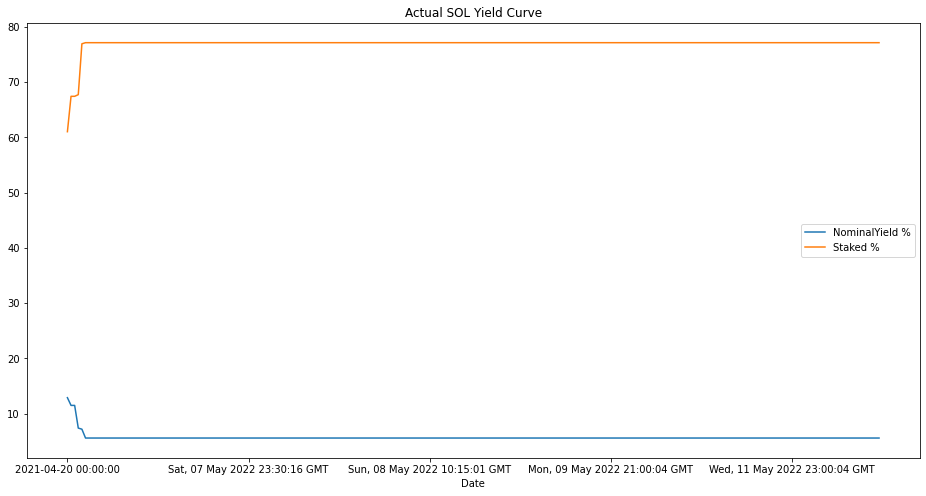

In [80]:
pl = merged_sol_df.plot(y=['NominalYield %','Staked %'],figsize=(16,8),title='Actual SOL Yield Curve')

In [81]:
eth_2_df = get_data("eth2.0")
eth_2_df

,index,Project,NominalYield %,Staked %,Inflation %,RealYield %,Lock-Up,Market Cap ($),Daily Vol ($)
Date,,,,,,,,,
"Sat, 07 May 2022 14:59:19 GMT",0,eth2.0,4.5,7.7,0.4,4.0,~12+ months,512.18,0.0
"Sat, 07 May 2022 14:59:20 GMT",1,eth2.0,4.5,7.7,0.4,4.0,~12+ months,512.18,0.0
"Sat, 07 May 2022 15:00:34 GMT",2,eth2.0,4.5,7.7,0.4,4.0,~12+ months,512.18,0.0
"Sat, 07 May 2022 15:00:35 GMT",3,eth2.0,4.5,7.7,0.4,4.0,~12+ months,512.18,0.0
"Sat, 07 May 2022 15:02:32 GMT",4,eth2.0,4.5,7.7,0.4,4.0,~12+ months,512.18,0.0
...,...,...,...,...,...,...,...,...,...
"Thu, 12 May 2022 19:00:04 GMT",211,eth2.0,4.4,7.7,0.4,4.0,~12+ months,512.18,0.0
"Thu, 12 May 2022 23:00:05 GMT",212,eth2.0,4.4,7.7,0.4,4.0,~12+ months,512.18,0.0
"Fri, 13 May 2022 23:00:04 GMT",213,eth2.0,4.4,7.7,0.4,4.0,~12+ months,512.18,0.0


In [82]:
merged_eth_df = pd.concat([eth_df,eth_2_df])
merged_eth_df.tail()

,index,Project,NominalYield %,Staked %,Inflation %,RealYield %,Lock-Up,Market Cap ($),Daily Vol ($),Yield %
Date,,,,,,,,,,
"Thu, 12 May 2022 19:00:04 GMT",211,eth2.0,4.4,7.7,0.4,4.0,~12+ months,512.18,0.0,NaN
"Thu, 12 May 2022 23:00:05 GMT",212,eth2.0,4.4,7.7,0.4,4.0,~12+ months,512.18,0.0,NaN
"Fri, 13 May 2022 23:00:04 GMT",213,eth2.0,4.4,7.7,0.4,4.0,~12+ months,512.18,0.0,NaN
"Sat, 14 May 2022 23:00:05 GMT",214,eth2.0,4.4,7.7,0.4,4.0,~12+ months,512.18,0.0,NaN
"Sun, 15 May 2022 23:00:05 GMT",215,eth2.0,4.4,7.7,0.4,4.0,~12+ months,512.18,0.0,NaN


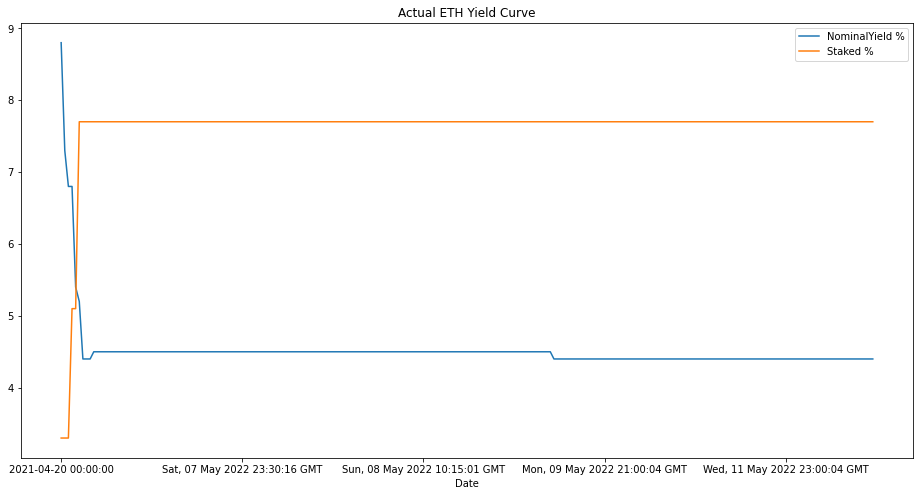

In [83]:
pl = merged_eth_df.plot(y=['NominalYield %','Staked %'],figsize=(16,8),title='Actual ETH Yield Curve')

/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


<AxesSubplot:xlabel='Date'>

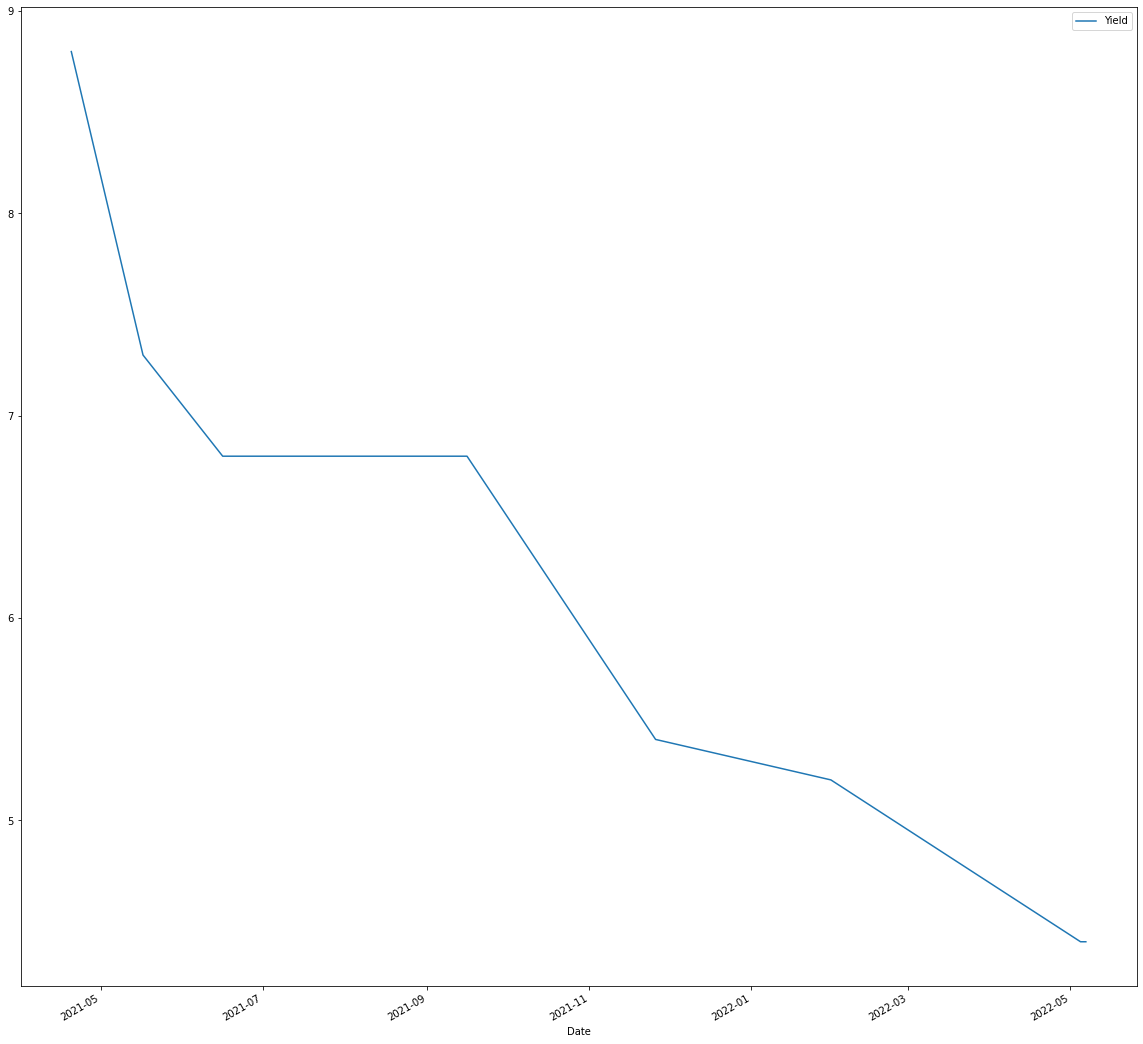

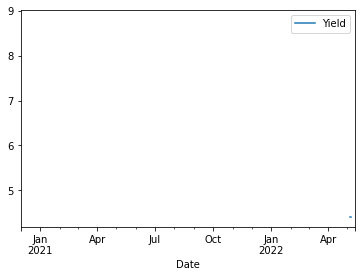

In [55]:
yield_df =  pd.DataFrame(columns=['Yield'])
yield_df['Date'] = pd.date_range(start=pd.datetime(2020, 12, 1), periods=530, freq='D')
yield_df.set_index('Date',inplace=True)
yield_df['Yield'] = eth_df['NominalYield %']
foo_df  = yield_df[yield_df['Yield'].notna()]
index_list = [i for i in range(0,len(foo_df.index))]
inter = interp1d(index_list,foo_df['Yield'])

#X2 = [i for i in range(0,9)]
#X2 = np.linspace(0,10,100)
#X2 = np.linspace(0,1,10)
#foo_yield = np.array([inter(x) for x in X2])
#foo_yield
#[inter(x) for x in X2]
#foo_yield
#yield_df
yield_df[yield_df['Yield'].notna()].plot(figsize=(20,20))
yield_df.plot()
#eth_df['NominalYield %']

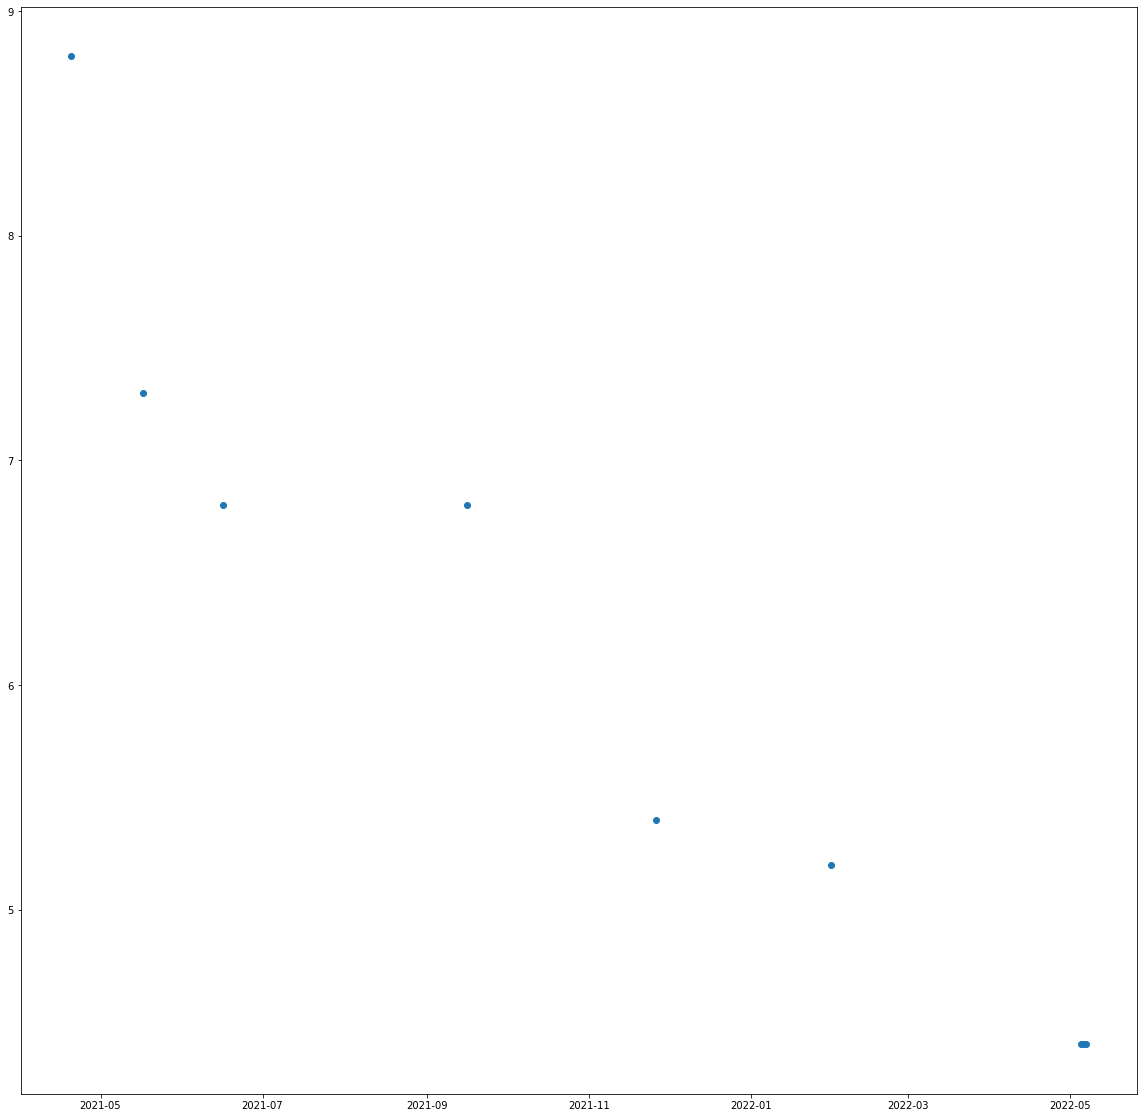

In [56]:
plt.figure(figsize=(20,20))
plt.scatter(yield_df.index,yield_df['Yield'])

In [57]:
X2 = np.linspace(0,1,10)
len(X2), X2

(10,
 array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]))

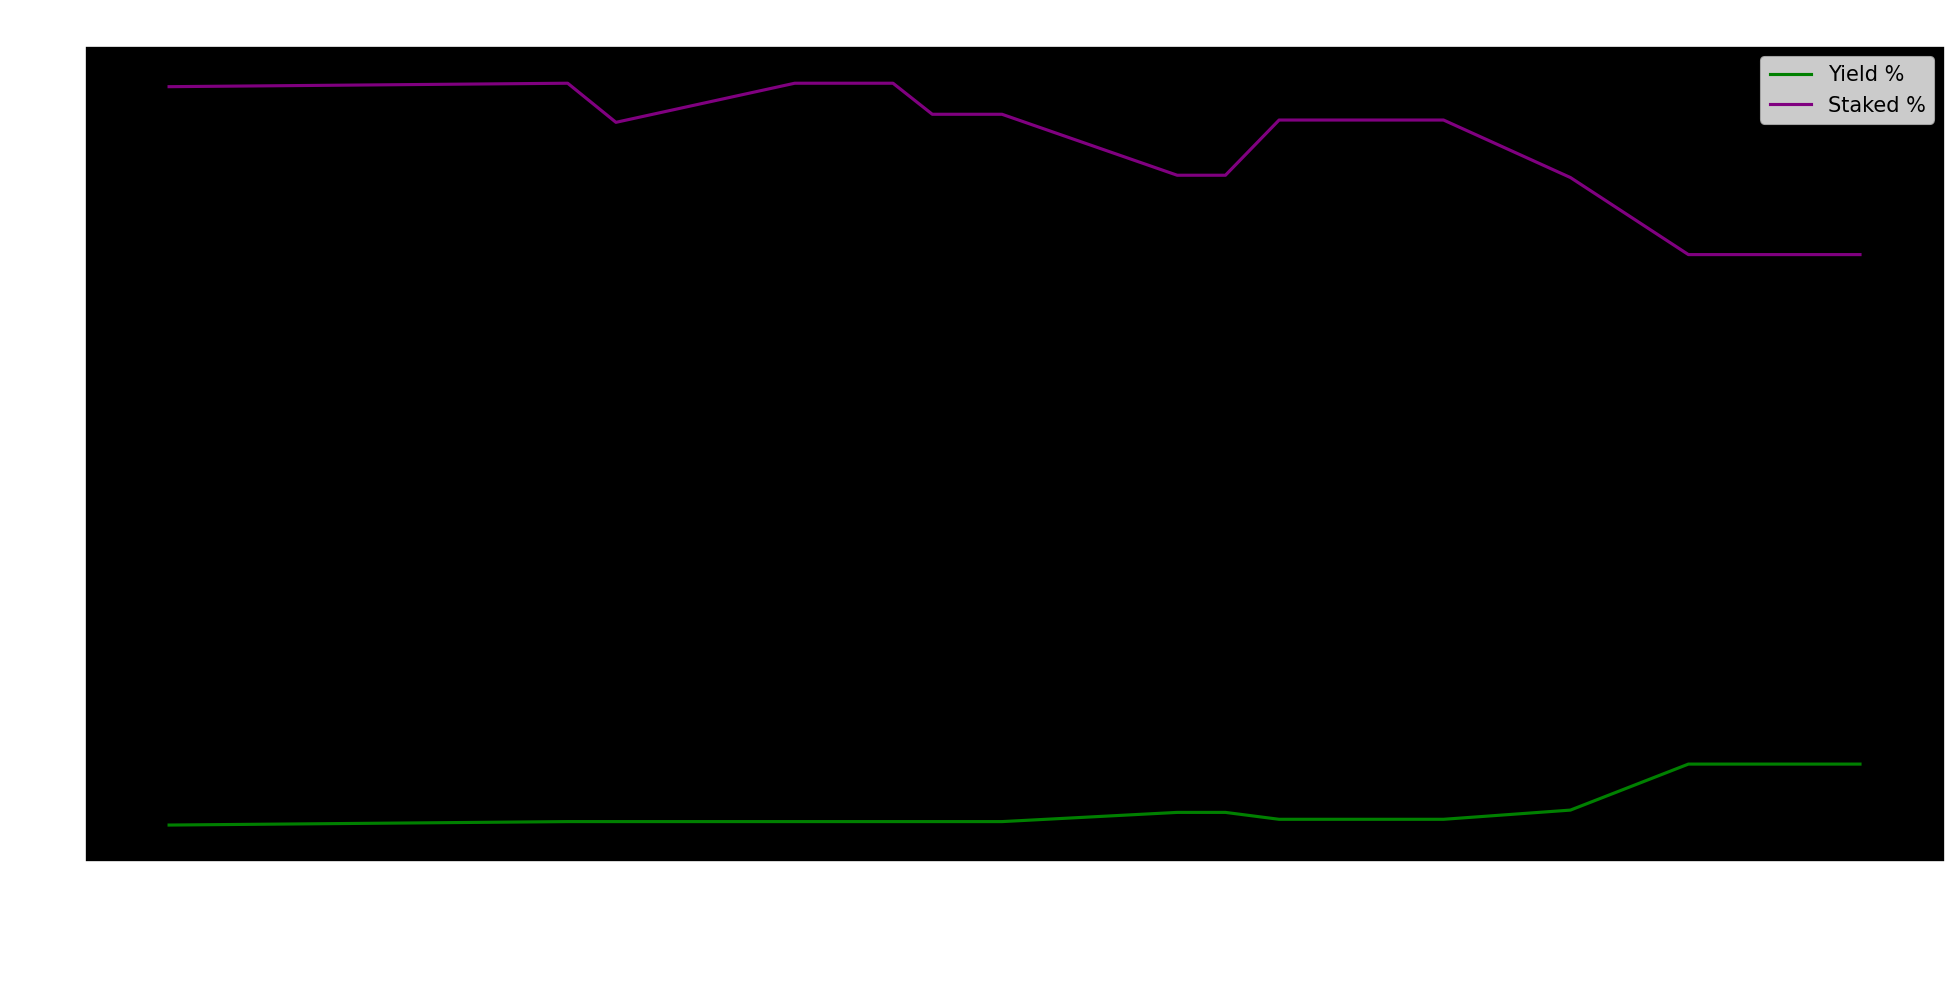

In [86]:
# code
# Visualizing The Open Price of all the stocks
  
# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)
ax = plt.axes()

ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.set_facecolor("black");
# using plot method to plot open prices.
# in plot method we set the label and color of the curve.
atom_df['NominalYield %'].plot(label='Yield %', color='green')
#eth_df['RealYield %'].plot(label='RealYield %', color='yellow')
atom_df['Staked %'].plot(label='Staked %', color='purple')
  
# adding title to the plot
plt.title('PSG Proprietary Model Staking Dynamics',color="white")
  
# adding Label to the y-axis
plt.ylabel('% Percentage Change',color='white')
    
# adding Label to the x-axis
plt.xlabel('Time Over 2 Years',color='white')
  
# adding legend to the curve
plt.legend()